In [1]:
from utils import set_pyplot_params
set_pyplot_params()

Nel capitolo precedente abbiamo risolto il problema delle 101 tazze, è come si è visto non si tratta di indovinare da quale tazza il biscotto proviene, si tratta di stimare le proporzioni.

In questo capitolo, facciamo un altro passo in avanti verso la statistica Bayesiana per risolvere il problema dell'Euro.
Partiremo con la stessa distribuzione a priori, e vedremo che l'aggiornamente è lo stesso, matematicamente parlando. Ma sosterrò che è un problema differente, filosoficamente e useremo questo per introdurre due elementi chiave della statistica Bayesiana:

* Scegliere la distribuzione a priori
* Usare la probabilità per rappresentare l'incognito.

## Il problema dell'euro

Le libro *Information Theory, Inference, and Learning Algorithms*, David MacKay pone questo problema:
Una affermazione statistica è apparsa sul *The Guardian* Venerdì 4 gennaio del 2002:

> Quando facciamo girare sul filo una moneta da un Euro Belga 250 volte otteniamo 140 volte testa e 110 volte coda. 'Sembra molto sospetto per me' disse Barry Blight, docente di statistica alla London School of Economics.
'Se la moneta fosse imparziale, la probabilità di ottenere un risultato così estremo sarebbe del 7%.'

"Ma come chiede MacKay con questi dati ci danno evidenza che la moneta è truccata piuttosto che giusta?"

Per rispondere a questa domanda, procederemo in due passi.
Primo useremo la distribuzione binomiale per vedere da dove proviene quel 7%; poi usereremo il teorema di Bayes per stimare la probabilità che questa moneta esca testa.

## La Distribuzione binomiale
Supponiamo ti dica che la moneta sia "giusta", così è, la probabilità di testa è 50%. Se la lanciamo due volte possiamo ottenere 4 risultati: `HH`, `HT`, `TH` e `TT`. Tutte e 4 le combinazioni hanno la stessa probabilità, 25%

Se sommiamo il numero totale delle teste, ci sono tre possibili risultati: 0,1 o 2. Le probabilità di 0 e 2 sono del 25%, 1/4.
Mentre la probabilità di 1 è 50% 2/4.

Più generalmente, supponiamo che la probabilità di testa sia $p$ e di far girare la moneta $n$ volte.
La probabilità di ottenere un numero totale $k$ di teste è dato dalla [distribuzione binomiale](https://en.wikipedia.org/wiki/Binomial_distribution):

$$\binom{n}{k} p^k (1-p)^{n-k}$$

per ogni valore $k$ da 0 a $n$ inclusi.
Il termine $\binom{n}{k}$ è il [coefficiente binomiale](https://en.wikipedia.org/wiki/Binomial_coefficient) e di solito si pronuncia "n scelto k".  

$$\binom{n}{k} = \frac{n!}{k!(n-k)!}$$

Possiamo valutare questa espressione da soli, ma possiamo usare la funzione di SciPy `binom.pmf`.
Per esempio, se landiamo una moneta `n=2` volte e la probabilità di avere testa è `p=0.5`, la probabilità di otterenere `k=1` testa:

from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

Invece di usare un singolo valore di `k`, possiamo usare `binom.pmf` con un array di valori.

In [3]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

Il risultato è un array Numpy con la probabilità di 0,1 o 2 teste. se mettiamo queste probabilità in un oggetto `Pmf` il risultato sarà la distribuzione di k per i valori di n e p.

Vediamo il risultato:

In [4]:
from distribution import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


La seguente funzione calcola la distribuzione binomiale per un valore di `n` e `p` e ritorna un oggetto `Pmf` che rappresenta il risultato.

In [5]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

Qui il risultato con `n=250` e `p=0.5`:

In [6]:
pmf_k = make_binomial(n=250, p=0.5)

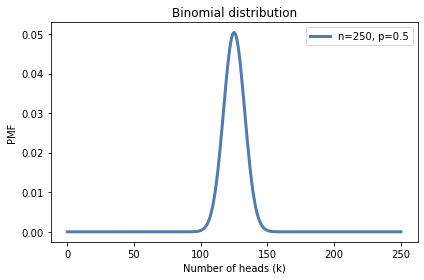

In [7]:
from utils import decorate

pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

La quantità più probabile della distribuzione è 125:

In [8]:
pmf_k.max_prob()

125

Ma sebbene questa sia la quantità più probabile, la probabilità che otteniamo con il valore di 125 teste è di circa il 5%

In [9]:
pmf_k[125]

0.050412213147309655

Nell'esempio di MacKay otteniamo 140 teste, che è meno probabile di 125:

In [12]:
pmf_k[140]

0.008357181724918204

Nell'articolo MacKay cita, gli statistici dicono "Se la moneta non è truccata la probabilità di ottenere un risultato estremo come questo dovrebbe essere meno del 7%".

Possiamo usare la distribuzione binomiale per controllare questo matematicamente.
La funzione seguente prende un PMF e calcola la probabilità totale di una quantita di essere maggiore o uguale al `threshold`. 

In [13]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

qui la probabilità di ottenere 140 teste o più:

In [14]:
prob_ge(pmf_k, 140)

0.03321057562002164

`Pmf` fornisce un metodo per fare lo stesso calcolo.

In [16]:
pmf_k.ge_dist(140)

0.03321057562002164